In [1]:
import proplot as plot
import numpy as np
import yaml
import glob
import copy

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import sys

import pizza_cutter

logging.basicConfig(stream=sys.stdout)
for code in ["ngmix", "metadetect", "pizza_cutter", "pizza_cutter_sims"]:
    logging.getLogger(code).setLevel(
        getattr(logging, "DEBUG"))

In [3]:
import tempfile
from pizza_cutter_sims.pizza_cutter import run_des_pizza_cutter_coadding_on_sim
from pizza_cutter_sims.sim import generate_sim
from pizza_cutter_sims.constants import PIXEL_SCALE
from pizza_cutter_sims.mdet import run_metadetect
from pizza_cutter_sims.stars import mask_stars

with open(glob.glob("../runs/run0033_*/config.yaml")[0]) as fp:
    base_cfg = yaml.safe_load(fp.read())

base_cfg['star']['apodize'] = {}
base_cfg['star']['apodize']['skip'] = True
base_cfg['star']['apodize']['delta'] = 1
base_cfg['star']['interp']['skip'] = True
# with open(glob.glob("ref_config.yaml")[0]) as fp:
#     base_cfg = yaml.safe_load(fp.read())
    
# base_cfg["se"]["n_images"] = 2
# base_cfg["pizza_cutter"]["single_epoch_config"]["spline_interp_flags"] = [7]

In [4]:
import tqdm

rng = np.random.RandomState()
seeds = rng.randint(low=1, high=2**29, size=5)

# all_msk_keys = ["bad_columns", "cosmic_rays", "streaks", "star", "star-noise"]
all_msk_keys = ["none", "star-interp", "star-noise", "star-apodize"]
results = {}
for msk_key in tqdm.tqdm(all_msk_keys):
    rng = np.random.RandomState(seed=seeds[0])
    gal_rng = np.random.RandomState(seed=seeds[1])
    star_rng = np.random.RandomState(seed=seeds[1])
    coadd_rng = np.random.RandomState(seed=seeds[2])
    mdet_rng = np.random.RandomState(seed=seeds[3])

    cfg = copy.deepcopy(base_cfg)
    for key in all_msk_keys:
        if key in ["bad_columns", "cosmic_rays", "streaks"]:
            cfg["msk"][key] = False
    for key in all_msk_keys:
        if key not in ["bad_columns", "cosmic_rays", "streaks"]:
            continue
        cfg["msk"][key] = True
        if key == msk_key:
            break
    
    if msk_key == "none":
        cfg["star"]["dens_factor"] = 0
    
    if msk_key == "star-interp":
        cfg['star']['apodize']['skip'] = True
        cfg['star']['interp']['skip'] = False
        cfg['star']['interp']['fill_isolated_with_noise'] = False
    elif msk_key == "star-noise":
        cfg['star']['apodize']['skip'] = True
        cfg['star']['interp']['skip'] = False
        cfg['star']['interp']['fill_isolated_with_noise'] = True
    elif msk_key == "star-apodize":
        cfg['star']['apodize']['skip'] = False
        cfg['star']['interp']['skip'] = True

    data = generate_sim(
        rng=rng,
        gal_rng=gal_rng,
        star_rng=star_rng,
        coadd_config=cfg["coadd"],
        se_config=cfg["se"],
        psf_config=cfg["psf"],
        gal_config=cfg["gal"],
        star_config=cfg["star"],
        layout_config=cfg["layout"],
        msk_config=cfg["msk"],
        shear_config=cfg["shear"],
        skip_coadding=False,
    )

    with tempfile.TemporaryDirectory() as tmpdir:
        cdata = run_des_pizza_cutter_coadding_on_sim(
            rng=coadd_rng,
            tmpdir=tmpdir,
            single_epoch_config=cfg["pizza_cutter"]["single_epoch_config"],
            img=data["img"],
            wgt=data["wgt"],
            msk=data["msk"],
            bkg=data["bkg"],
            info=data["info"],
            n_extra_noise_images=0,
        )
        
    mask_stars(
        cdata=cdata, 
        stars=data["stars"], 
        rng=star_rng,
        interp_cfg=cfg["star"]["interp"],
        apodize_cfg=cfg["star"]["apodize"],
    )
    
    results[msk_key] = cdata

  0%|                                                                                                                                                           | 0/4 [00:00<?, ?it/s]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:pre-processing image epoch

 25%|████████████████████████████████████▊                                                                                                              | 1/4 [00:04<00:13,  4.37s/it]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
DEBUG:pizza_cutter_sims.stars:generating 10 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_piz

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 2/4 [00:08<00:08,  4.43s/it]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
DEBUG:pizza_cutter_sims.stars:generating 10 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_piz

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 3/4 [00:11<00:03,  3.83s/it]

DEBUG:pizza_cutter_sims.wcs:generated wcs: galsim.AffineTransform(0.263, 0.0, 0.0, 0.263, origin=galsim.PositionD(x=233.0, y=233.0), world_origin=galsim.PositionD(x=0.0, y=0.0))
DEBUG:pizza_cutter_sims.psf:psf config: {'type': 'Gaussian', 'fwhm': 0.9, 'shear': {'type': 'G1G2', 'g1': 0.0, 'g2': 0.0}}
DEBUG:pizza_cutter_sims.psf:galsim psf: galsim.Gaussian(sigma=0.3821948101296086).transform(1.0,0.0,0.0,1.0)
DEBUG:pizza_cutter_sims.gals:using 'exp-super-bright' gal type w/ mag 14.0
DEBUG:pizza_cutter_sims.stars:generating 10 stars
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for coadd/coadd
INFO:pizza_cutter.des_pizza_cutter._load_info:loading image data products for epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:generating slice objects for ra,dec = 0.0|0.0
DEBUG:pizza_cutter.des_pizza_cutter._coadd_slices:found possible image epoch0/epoch0
INFO:pizza_cutter.des_pizza_cutter._coadd_slices:images found in rough cut: 1
INFO:pizza_cutter.des_piz

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.72s/it]


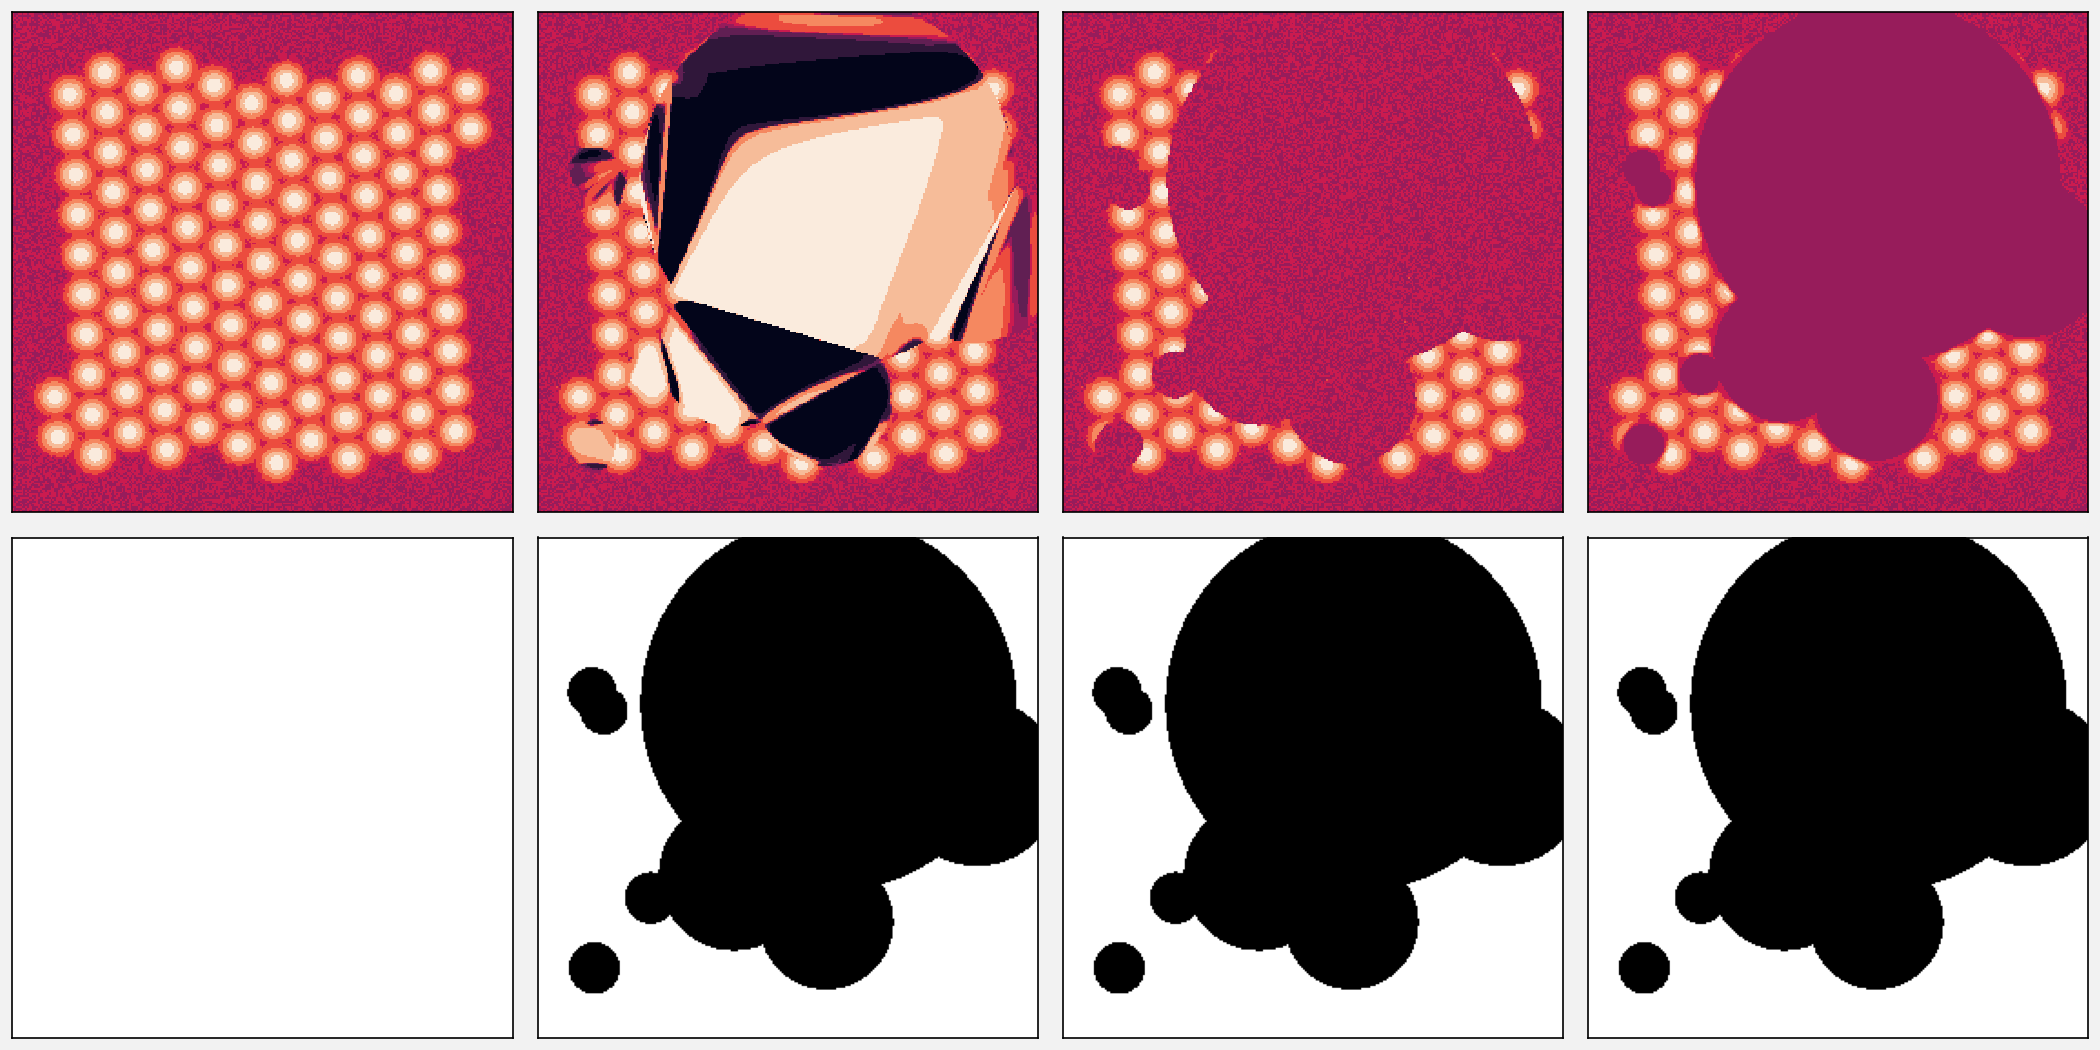

In [5]:
vmin = np.inf
vmax = -np.inf
trans = np.arcsinh

for i, key in enumerate(all_msk_keys):
    img = results[key]["image"].copy()
    wgt = results[key]["weight"].copy()
    ormask = results[key]["ormask"].copy()
    msk = wgt == 0
    wgt[msk] = np.median(wgt[~msk])
    
    vv = trans(img*np.sqrt(wgt))
    vmin = min(np.min(vv), vmin)
    vmax = max(np.max(vv), vmax)

fig, axs = plot.subplots(nrows=2, ncols=len(all_msk_keys), share=3)
for i, key in enumerate(all_msk_keys):
    img = results[key]["image"]
    wgt = results[key]["weight"].copy()
    ormask = results[key]["ormask"]
    msk = wgt == 0
    wgt[msk] = np.median(wgt[~msk])
    ax = axs[0, i]
    ax.pcolormesh(trans(img*np.sqrt(wgt)), cmap="rocket", vmin=vmin, vmax=vmax)
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
    ax = axs[1, i]
    ax.imshow(ormask.astype(bool), cmap="gray_r", vmin=0, vmax=1, origin='lower')    
    ax.grid(False)
    ax.format(xtickloc='neither', ytickloc='neither')
    
# fig.savefig("msk.png")

In [ ]:
mdet_res = run_metadetect(
    rng=mdet_rng,
    config=cfg["metadetect"],
    wcs=data["info"]["affine_wcs"],
    image=cdata["image"],
    bmask=cdata["bmask"],
    ormask=cdata["ormask"],
    noise=cdata["noise"],
    psf=cdata["psf"],
    weight=cdata["weight"],
    mfrac=cdata["mfrac"],
    mask_catalog=data["stars"],
    mask_expand_rad=cfg["star"]["mask_expand_rad"]
)

In [ ]:
fig, axs = plot.subplots(figsize=(12, 12))
cdata = results["star"]

img = cdata["image"].copy() - results['no-star']['image']
msk = cdata['mfrac'] == 1
# img[msk] = np.nan

key = "image"
axs.pcolormesh(img, cmap="rocket")
# axs.plot(mdet_res['noshear']['sx_col_noshear'], mdet_res['noshear']['sx_row_noshear'], 'b.')

# axs.plot(mdet_res['1p']['sx_col'], mdet_res['1p']['sx_row'], '+', color='cyan')
# axs.plot(mdet_res['1m']['sx_col'], mdet_res['1m']['sx_row'], '+', color='green')

# axs.plot(mdet_res['2p']['sx_col'], mdet_res['2p']['sx_row'], 'x', color='cyan')
# axs.plot(mdet_res['2m']['sx_col'], mdet_res['2m']['sx_row'], 'x', color='green')


axs.set_aspect(1)
axs.set_title(key)
axs.set_xlim(0, img.shape[1])

# fig.savefig('star_sel.pdf')


In [6]:
from ngmix.metacal import get_all_metacal

import numpy as np

import ngmix
from metadetect.metadetect import do_metadetect
from pizza_cutter_sims.stars import (
    BMASK_GAIA_STAR,
    BMASK_EXPAND_GAIA_STAR,
    apply_mask_bit_mask,
)


def _make_mbobs(
    *, wcs, image, bmask, ormask,
    noise, psf, weight, mfrac,
):
    psf_cen = (psf.shape[0] - 1)/2
    im_cen = (image.shape[0] - 1)/2

    # make the mbobs
    psf_jac = ngmix.jacobian.Jacobian(
        x=psf_cen,
        y=psf_cen,
        dudx=wcs.dudx,
        dudy=wcs.dudy,
        dvdx=wcs.dvdx,
        dvdy=wcs.dvdy,
    )
    target_s2n = 500.0
    target_noise = np.sqrt(np.sum(psf ** 2)) / target_s2n
    psf_obs = ngmix.Observation(
        psf.copy(),
        weight=np.ones_like(psf)/target_noise**2,
        jacobian=psf_jac,
    )

    im_jac = ngmix.jacobian.Jacobian(
        x=im_cen,
        y=im_cen,
        dudx=wcs.dudx,
        dudy=wcs.dudy,
        dvdx=wcs.dvdx,
        dvdy=wcs.dvdy,
    )
    obs = ngmix.Observation(
        image.copy(),
        weight=weight.copy(),
        bmask=bmask.copy(),
        ormask=ormask.copy(),
        jacobian=im_jac,
        psf=psf_obs,
        noise=noise.copy(),
        mfrac=np.clip(mfrac.copy(), 0, 1),
    )

    mbobs = ngmix.MultiBandObsList()
    obslist = ngmix.ObsList()
    obslist.append(obs)
    mbobs.append(obslist)
    return mbobs

In [7]:
mcal_res = {}
for key in all_msk_keys:
    cdata = results[key]
    mcal_res[key] = get_all_metacal(
        _make_mbobs(
            wcs=data["info"]["affine_wcs"],
            image=cdata["image"],
            bmask=cdata["bmask"],
            ormask=cdata["ormask"],
            noise=cdata["noise"],
            psf=cdata["psf"],
            weight=cdata["weight"],
            mfrac=cdata["mfrac"],
        ),
        psf='fitgauss',
        fixnoise=True,
        use_noise_image=True,
        types=['noshear'],
        rng=np.random.RandomState(seed=10),
    )

DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image
DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image
DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image
DEBUG:ngmix.metacal.convenience:    Doing fixnoise with input noise image


star-interp -0.5947000700274199
star-noise -1.113692505518896
star-apodize -0.6025016615448975


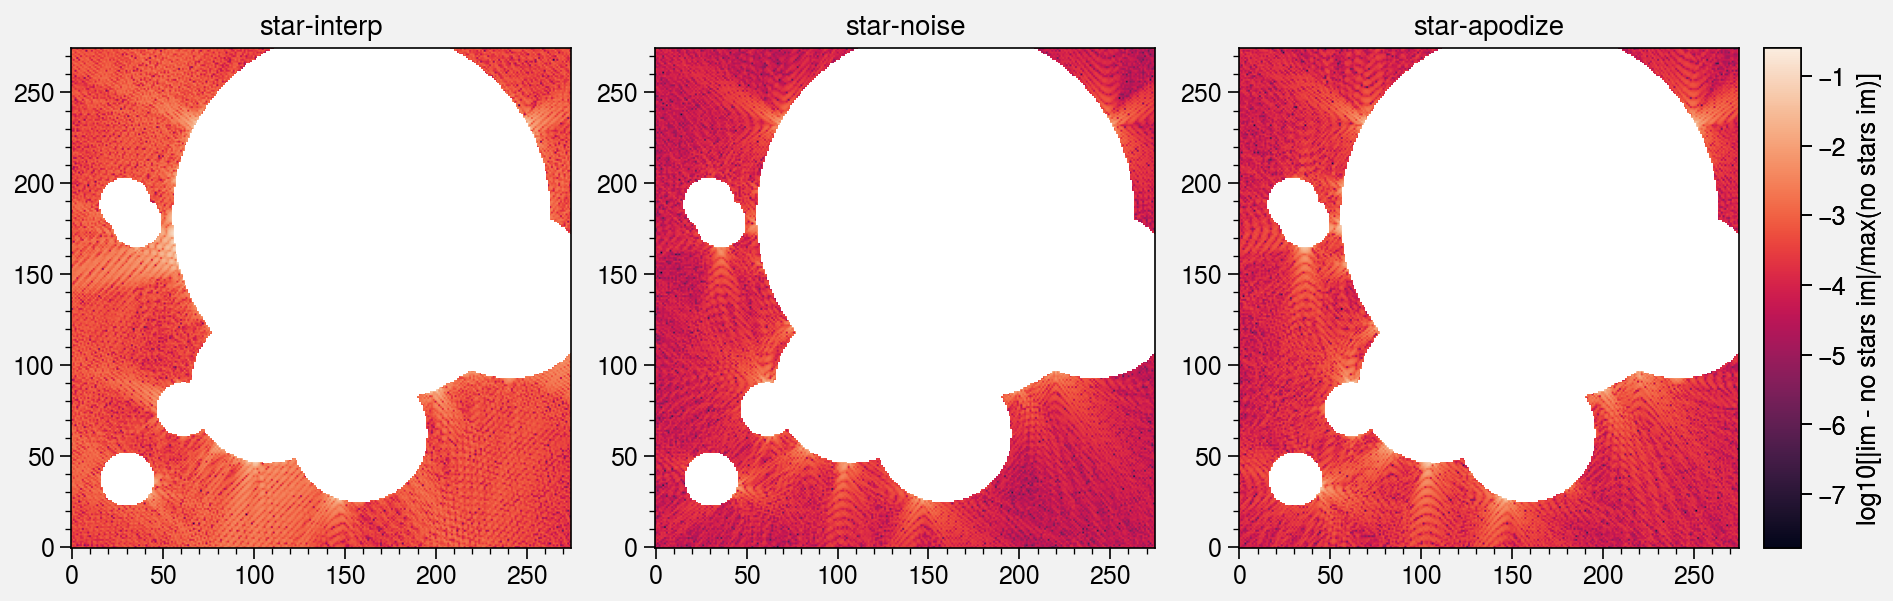

In [8]:
fig, axs = plot.subplots(nrows=1, ncols=3, share=0)

ms = []
maps = []
for i, key in enumerate(['star-interp', 'star-noise', 'star-apodize']):
    
    dim = mcal_res[key]['noshear'][0][0].image - mcal_res['none']['noshear'][0][0].image
    msk = results['star-interp']["ormask"].astype(bool)
    dim /= np.nanmax(mcal_res['none']['noshear'][0][0].image)
    dim[msk] = np.nan
    maps.append(np.log10(np.abs(dim)))

for i, key in enumerate(['star-interp', 'star-noise', 'star-apodize']):
    ax = axs[i]
    ms.append(
        ax.imshow(
            maps[i],
            cmap='rocket', 
            origin='lower', 
            vmin=np.nanmin(maps), 
            vmax=np.nanmax(maps),
        )
    )
    ax.grid(False)
    ax.set_title(key)
    print(key, np.nanmax(maps[i]))

fig.colorbar(ms[0], loc='r', label='log10[|im - no stars im|/max(no stars im)]')


In [ ]:
fig, axs = plot.subplots(nrows=3, ncols=2, figsize=(8, 16), share=0)
cdata = results["star"]

for i, key in enumerate(["image", "bmask", "ormask", "noise", "mfrac", "weight"]):
    axs[i].pcolormesh(cdata[key], cmap="rocket")
    axs[i].set_aspect(1)
    axs[i].set_title(key)

In [ ]:
fig, axs = plot.subplots(figsize=(10, 10))
cdata = results["star"]

key = "image"
axs.pcolormesh(cdata[key], cmap="rocket")
axs.set_aspect(1)
axs.set_title(key)

In [ ]:
np.max(np.abs(results['star']['image'] - results['star-noise']['image']))